In [1]:
import os
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

os.environ['TF_USE_LEGACY_KERAS'] = '1';

In [2]:
input_default_json_conf_file='fcnn_emotion4_kfold_default.json';

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import json

2024-07-26 21:50:37.490720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 21:50:39.021631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import sys
sys.path.append('../library');

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-07-26 21:50:40.956002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-26 21:50:41.078483: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-26 21:50:41.078884: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
## Load json conf json file
fd = open(os.path.join('./',input_default_json_conf_file));
DATA = json.load(fd);
fd.close()

# Variable globales

In [7]:
## Seed for the random variables
seed_number = 0;

## Dataset 
dataset_base_dir    = DATA["dataset_base_dir"]; 
dataset_labels_file = DATA['dataset_labels_file'];
dataset_name        = DATA['dataset_name'];

## Kfold 
K                 = DATA["kfold"]; # Variable K of kfold
enable_stratified = DATA["enable_stratified"]; # True: Stratified kfold False: Enable kfold 

## Training hyperparameters
EPOCAS     = DATA["epochs"];
BATCH_SIZE = DATA["batch_size"];

## Output
output_base_dir = DATA["output_base_dir"];

## Output json file
fold_status_file='kfold_data_results.json';

patience=max(10,int(EPOCAS/5));
NCOD=15;
ANGLE=60;

# Parametros de entrada

In [8]:
for n in range(len(sys.argv)):
    if sys.argv[n]=='--dataset-dir':
        dataset_base_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-file':
        dataset_labels_file=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-name':
        dataset_name=sys.argv[n+1];
    elif sys.argv[n]=='--kfold':
        K=int(sys.argv[n+1]);
    elif sys.argv[n]=='--enable-stratified':
        enable_stratified=bool(sys.argv[n+1]);
    elif sys.argv[n]=='--epochs':
        EPOCAS=int(sys.argv[n+1]);
    elif sys.argv[n]=='--batch-size':
        BATCH_SIZE=int(sys.argv[n+1]);
    elif sys.argv[n]=='--ncod':
        NCOD=int(sys.argv[n+1]);
    elif sys.argv[n]=='--patience':
        patience=int(sys.argv[n+1]);
    elif sys.argv[n]=='--seed':
        seed_number=int(sys.argv[n+1]);
    elif sys.argv[n]=='--output-dir':
        output_base_dir=sys.argv[n+1];
        
print('   dataset_base_dir:',dataset_base_dir)
print('dataset_labels_file:',dataset_labels_file)
print('       dataset_name:',dataset_name)
print('                  K:',K)
print('  enable_stratified:',enable_stratified)
print('             EPOCAS:',EPOCAS)
print('         BATCH_SIZE:',BATCH_SIZE)
print('               NCOD:',NCOD)
print('           patience:',patience)
print('        seed_number:',seed_number)
print('    output_base_dir:',output_base_dir)

   dataset_base_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-SKELETON
dataset_labels_file: train.csv
       dataset_name: ber2024-skel
                  K: 5
  enable_stratified: True
             EPOCAS: 20
         BATCH_SIZE: 1024
               NCOD: 15
           patience: 10
        seed_number: 0
    output_base_dir: /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4_1


# Set seed of random variables


In [9]:
np.random.seed(seed_number)
tf.keras.utils.set_random_seed(seed_number);

# Setting the cross-validation kfold


In [10]:
from sklearn.model_selection import KFold, StratifiedKFold

output_dir = os.path.join(output_base_dir,dataset_name,'cross-validation','onlycls_ncod'+str(NCOD));

if enable_stratified:
    kf = StratifiedKFold(n_splits = K, shuffle = True, random_state = seed_number);
else:
    kf  = KFold(n_splits = K, shuffle=True, random_state=seed_number); 

# Loading data of dataset

In [11]:
# Load filenames and labels
train_val_df = pd.read_csv(os.path.join(dataset_base_dir,dataset_labels_file));
print(train_val_df)
# Setting labels
Y   = train_val_df[['label']];
L=np.shape(Y)[0];

              d0         d1        d2         d3          d4        d5  \
0      879.99710  221.82512  0.992357  912.98303  200.273600  0.992427   
1      572.16200  279.02695  0.992407  590.67910  245.407620  0.994159   
2      371.21080  162.51218  0.994968  407.82455  147.418180  0.998588   
3      784.70400  188.59518  0.991716  810.64910  151.137180  0.993262   
4      599.16626  226.36893  0.996303  632.05560  205.994430  0.998727   
...          ...        ...       ...        ...         ...       ...   
26988  735.86580  140.05266  0.991446  779.04450  117.196396  0.998176   
26989  659.38010  165.69905  0.992050  686.48920  145.415340  0.991912   
26990  437.41483  247.45741  0.994472  464.44342  222.468220  0.989997   
26991  467.43167  216.45421  0.987527  473.09644  200.142960  0.980915   
26992  741.76196  134.74731  0.997798  736.93207  119.776710  0.949835   

              d6          d7        d8         d9  ...  d42  d43  d44  d45  \
0      857.93600  194.621660  0.9

# Auxiliar function

In [12]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

# Creating output directory

In [13]:
os.makedirs(output_dir,exist_ok = True) 
print(output_dir)


/media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4_1/ber2024-skel/cross-validation/onlycls_ncod15


# Creating output status file

In [14]:
json_status_path=os.path.join(output_dir,fold_status_file);

# Cross-validation

In [15]:
import SkeletonEmotion4Lib.lib_model as mpp
#import matplotlib.pyplot as plt

list_train_index=[];
list_val_index=[];
for train_index, val_index in kf.split(np.zeros(L),Y):
    list_train_index.append(train_index);
    #print('train_index:',train_index);
    list_val_index.append(val_index);
    #print('val_index:',val_index);

data_fold =  {'val_categorical_accuracy': [],
              'val_loss': [], 
              'train_categorical_accuracy': [],
              'train_loss': [] 
             };

fold_var=1;

if os.path.isfile(json_status_path):
    # Read JSON file
    with open(json_status_path) as data_file:
        data_fold = json.load(data_file)
        fold_var=len(data_fold['val_loss'])+1;


Fold: 1
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 4)                 8128      
                                                                 
Total params: 8128 (31.75 KB)
Trainable params: 8128 (31.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
22/22 [==============================] - ETA: 0s - loss: 1.3584 - categorical_accuracy: 0.3206
Epoch 1: val_loss improved from inf to 1.29941, saving model to /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4_1/ber2024-skel/cross-validation/onlycls_ncod15/model_1.h5
22/22 [==============================] - 3s 64ms/step - loss: 1.3584 - categorical_accuracy: 0.3206 - val_loss: 1.2994 - val_categorical_accuracy: 0.3608
Epoch 2/20
22/22 [==============================] - ETA: 0s - loss: 1.2885 - categorical_accuracy:

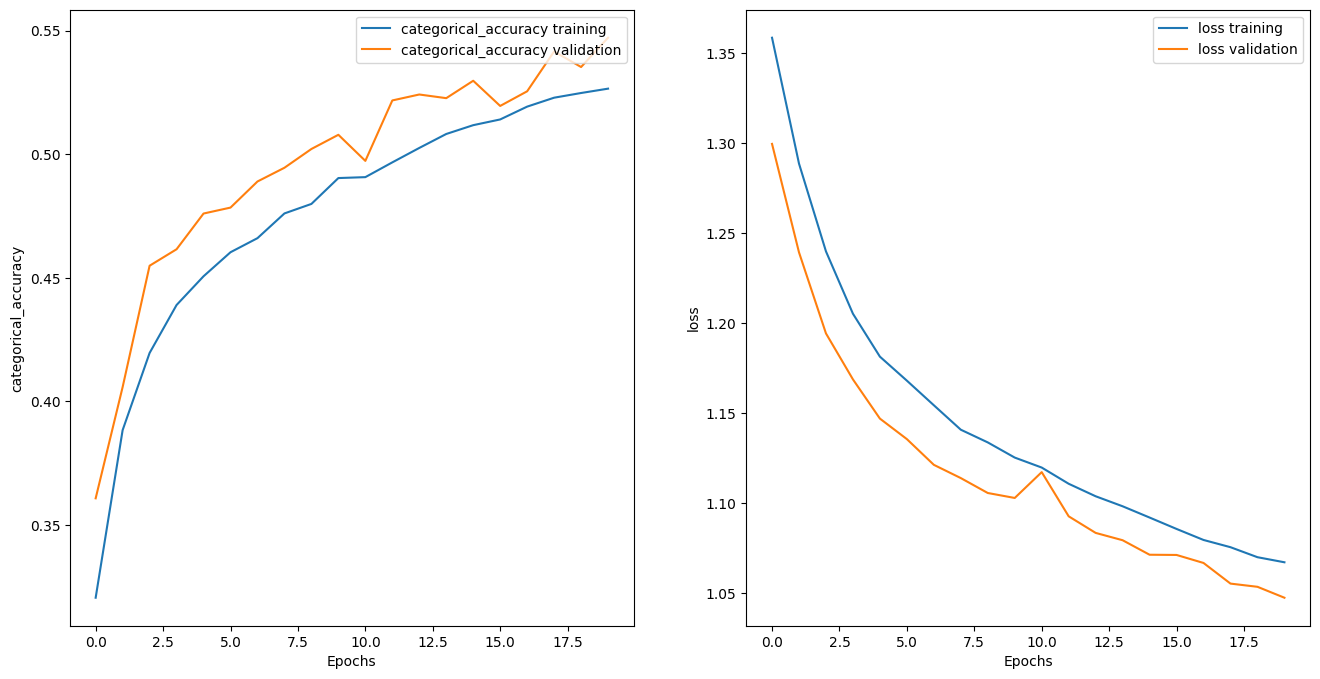

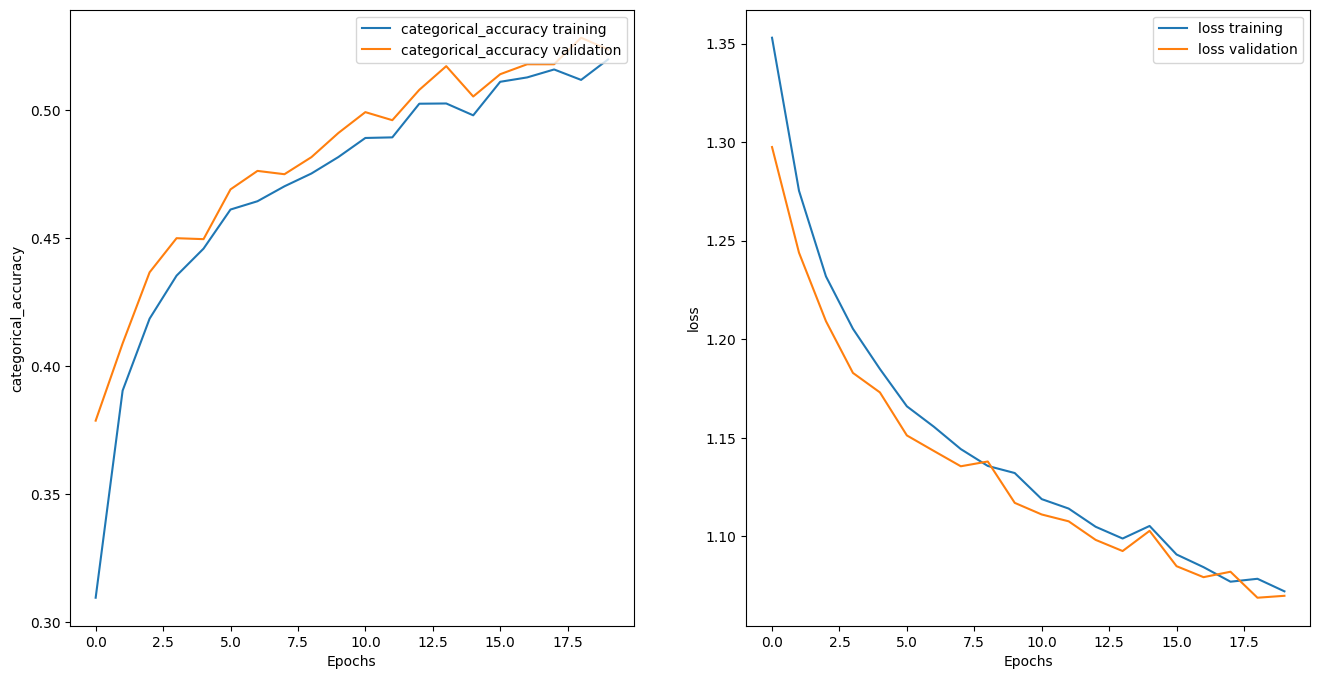

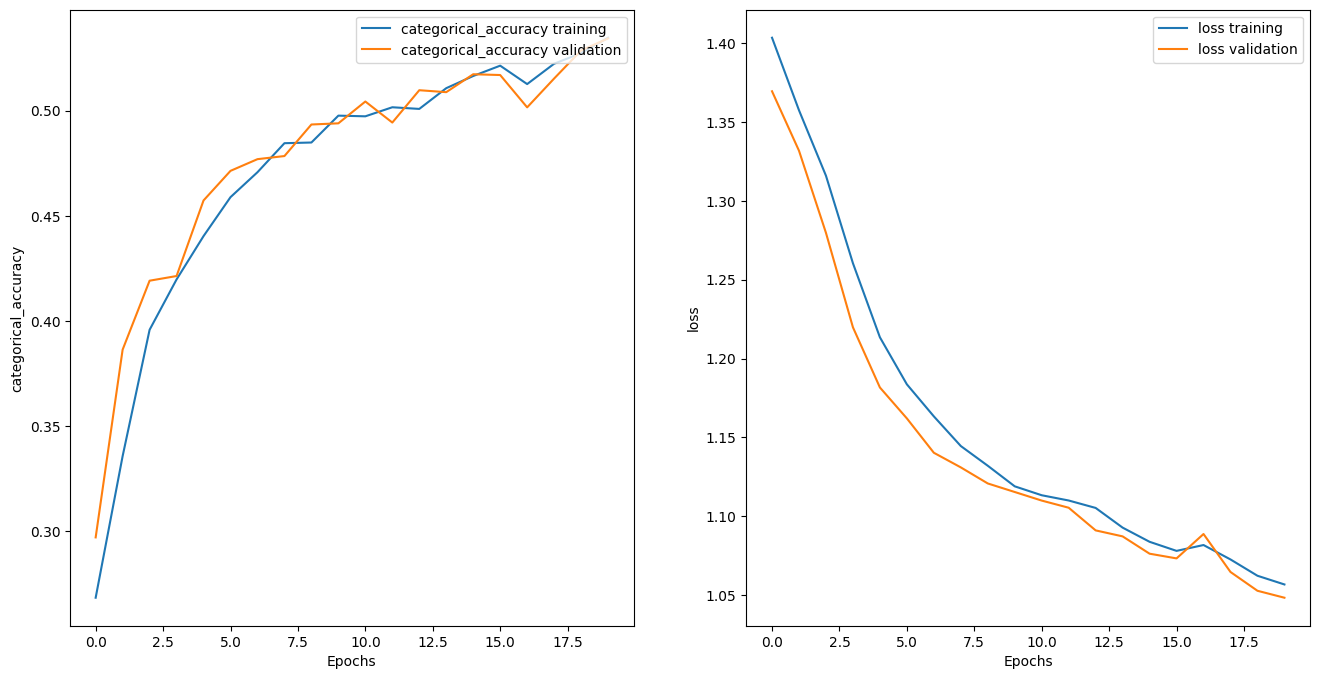

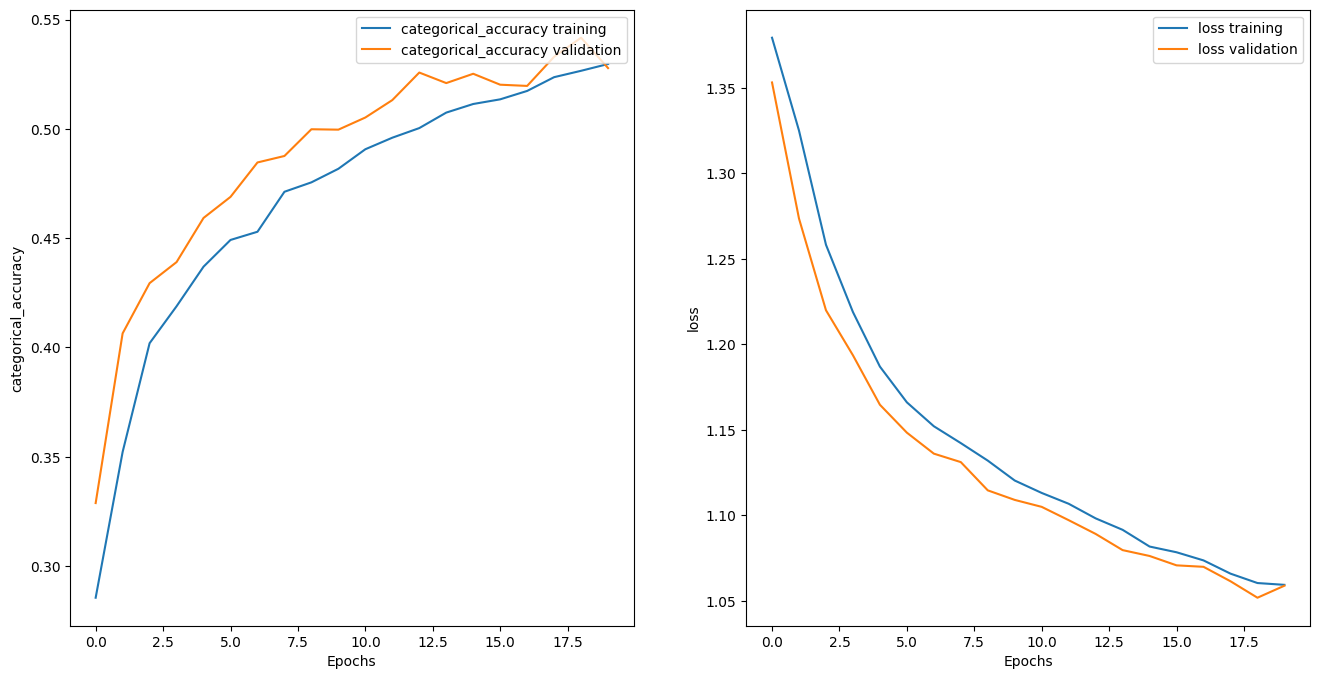

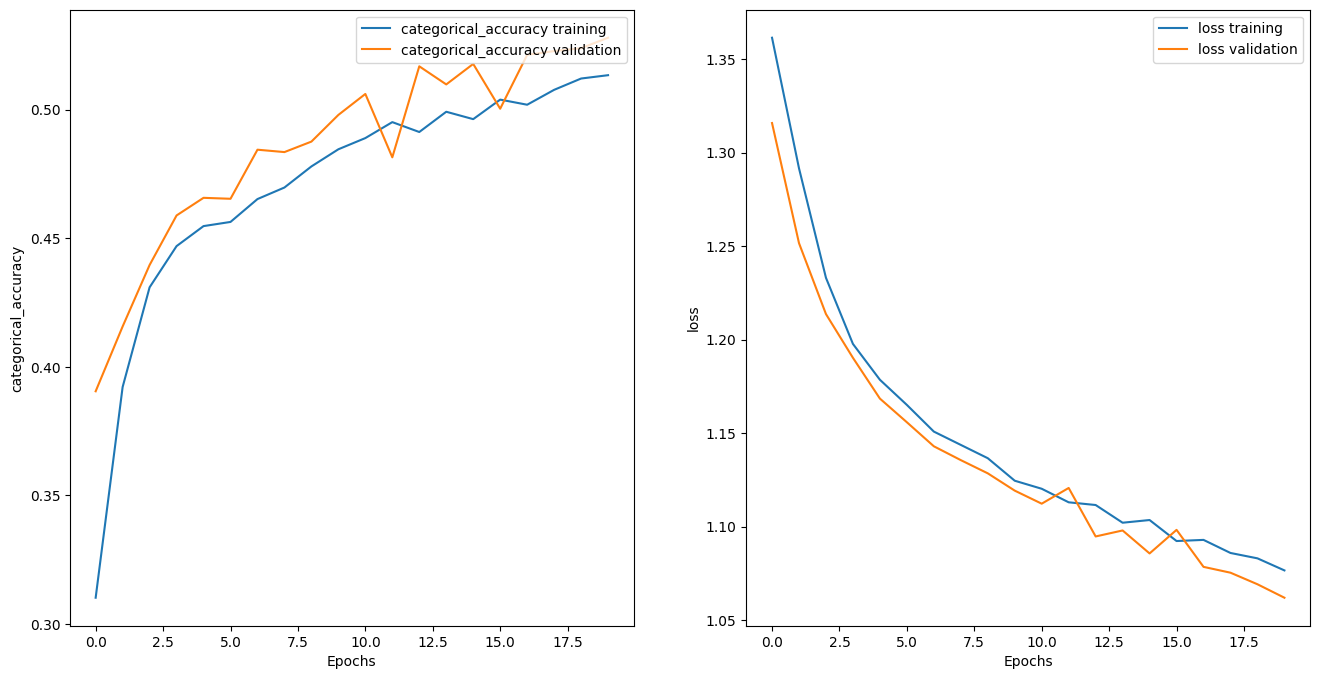

In [17]:
import SkeletonEmotion4Lib.DataAugmentation as sda
import SkeletonEmotion4Lib.lib_tools as slt

while fold_var<=K:
    training_df   = train_val_df.iloc[list_train_index[fold_var-1]]
    validation_df = train_val_df.iloc[list_val_index[fold_var-1]]

    print('\nFold:',fold_var);
    
    # CREATE NEW MODEL
    model = mpp.create_model_onlycls(load_weights=False,
                                    file_of_weight='',
                                    ncod=NCOD);
    
    model.summary()

    training_data_array   = slt.batch_normalize_coordinates(training_df.iloc[:,0:51].values)
    validation_data_array = slt.batch_normalize_coordinates(validation_df.iloc[:,0:51].values)
    
    training_dataset = sda.DataAugmentationClsGenerator(training_data_array, 
                                                        training_df.iloc[:,51].values,
                                                        batch_size=BATCH_SIZE, 
                                                        augment_fn=lambda X: slt.batch_random_rotate_coordinates(X,angle=ANGLE),
                                                        shuffle=True);
    
    validation_dataset = sda.DataAugmentationClsGenerator(  validation_data_array, 
                                                            validation_df.iloc[:,51].values,
                                                            batch_size=BATCH_SIZE, 
                                                            augment_fn=None,
                                                            shuffle=True);

    
    #STEPS_BY_EPOCHS=len(training_dataset);
    

    
    # COMPILE NEW MODEL
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_accuracy'])
    
    # CREATE CALLBACKS
    best_model_file=os.path.join(output_dir,get_model_name(fold_var));
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_file, 
                                                    save_weights_only=True,
                                                    monitor='val_loss', 
                                                    save_best_only=True, 
                                                    verbose=1);
    # Definindo o callback EarlyStopping
    early_stopping = tf.keras.callbacks.EarlyStopping(  monitor='val_loss', 
                                                        patience=patience,  
                                                        verbose=1, 
                                                        restore_best_weights=False);
    
    log_dir = os.path.join(output_dir,"logs","fit", "fold"+str(fold_var)+'_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"));
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(training_dataset,
                        #steps_per_epoch=STEPS_BY_EPOCHS,
                        epochs=EPOCAS,
                        validation_data=validation_dataset,
                        callbacks=[checkpoint,early_stopping,tensorboard_callback],
                        verbose=1
                       );
    
    #PLOT HISTORY
    mpp.save_model_history(history,
                           os.path.join(output_dir,"historical_"+str(fold_var)+".csv"),
                           show=False,
                           labels=['categorical_accuracy','loss']);
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(best_model_file);

    print("\n")
    
    # Evaluate training
    results = model.evaluate(training_dataset);
    results = dict(zip(model.metrics_names,results));
    print("Training:\n",results,"\n\n");
    data_fold['train_categorical_accuracy'].append(results['categorical_accuracy']);
    data_fold['train_loss'].append(results['loss']);

    # Evaluate validation
    results = model.evaluate(validation_dataset)
    results = dict(zip(model.metrics_names,results))
    print("Validation:\n",results,"\n\n");
    data_fold['val_categorical_accuracy'].append(results['categorical_accuracy'])
    data_fold['val_loss'].append(results['loss'])

    data_fold['number_of_parameters']=mpp.get_model_parameters(model);
    data_fold['ncod']=NCOD;
    data_fold['epochs']=EPOCAS;
    data_fold['patience']=patience;
    data_fold['seed']=seed_number;
    
    # Data fold
    with open(json_status_path, 'w') as f:
        json.dump(data_fold, f,indent=4);

    tf.keras.backend.clear_session()
    
    fold_var += 1

In [20]:
import json


data_fold['mean_val_categorical_accuracy'] = np.mean(data_fold['val_categorical_accuracy']);
data_fold['std_val_categorical_accuracy']  = np.std(data_fold['val_categorical_accuracy']);

data_fold['mean_val_loss'] = np.mean(data_fold['val_loss']);
data_fold['std_val_loss']  = np.std(data_fold['val_loss']);

data_fold['mean_train_categorical_accuracy'] = np.mean(data_fold['train_categorical_accuracy']);
data_fold['std_train_categorical_accuracy']  = np.std(data_fold['train_categorical_accuracy']);

data_fold['mean_train_loss'] = np.mean(data_fold['train_loss']);
data_fold['std_train_loss']  = np.std(data_fold['train_loss']);

print(json.dumps(data_fold, indent=4))

# Data fold
with open(json_status_path, 'w') as f:
    json.dump(data_fold, f,indent=4);

{
    "val_categorical_accuracy": [
        0.532691240310669,
        0.5471383333206177,
        0.5284311771392822,
        0.5343582034111023,
        0.5416821241378784,
        0.5279732942581177
    ],
    "val_loss": [
        1.0662542581558228,
        1.0473461151123047,
        1.0688059329986572,
        1.0483720302581787,
        1.051758885383606,
        1.0620232820510864
    ],
    "train_categorical_accuracy": [
        0.5188478231430054,
        0.5300546288490295,
        0.5238955020904541,
        0.5392701625823975,
        0.5284093618392944,
        0.5191479325294495
    ],
    "train_loss": [
        1.079420804977417,
        1.0593055486679077,
        1.0691179037094116,
        1.045698881149292,
        1.0565226078033447,
        1.0686463117599487
    ],
    "number_of_parameters": 8128,
    "ncod": 15,
    "epochs": 20,
    "patience": 10,
    "seed": 0,
    "mean_val_categorical_accuracy": 0.5353790620962778,
    "std_val_categorical_accuracy": 0.